# __<font color=blue>PHOTOTAXIS INDEX DATA PROCESSING (IMAGEJ TO  PYTHON)</font>__

### Importing modules

In [1]:
import numpy as np
import os
import re
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

### Initializing functions

In [2]:
def pval(p_value):
    'convert p values to astrixes'
    if p_value < 0.001:
        significance = '***'
    elif p_value < 0.01:
        significance = '**'
    elif p_value < 0.1:
        significance = '*'
    else:
        significance = ' '
    return significance

def cohens_effect_size(d1, d2):
    n1, n2 = len(d1), len(d2)
    s1, s2 = np.var(d1, ddof=1), np.var(d2, ddof=1)
    s = np.sqrt(((n1 - 1) * s1 + (n2 - 1) * s2) / (n1 + n2 - 2)) # calculate the pooled standard deviation
    u1, u2 = np.mean(d1), np.mean(d2) # means
    return (u1 - u2) / s # calculate the effect size

def convert_to_table(df,
                     averageBY='strain',
                     print_effect_size=False,
                     print_count=True,
                     print_LaTex=False,
                     stat_test=None,
                     control=None, 
                     order=None):
    """
    Convert a DataFrame into a table of averages, standard deviations and p-values.

    Args:
        df (pd.DataFrame): The input type. #I WANT TO ADD compatibility to accept LISTS LATER
        average_by (str): The column name of the category to average by
        print_count (bool): Whether to print total track count. Default: False. 
                            CURRENTLY ONLY WORKS WHEN STAT_TEST==None
        print_latex (bool): Whether to print LaTeX table. Default: False.
        stat_test (str): The statistical test to perform. Default: None.
            Options: 
                1. ttest_ind: independent t-test
                2. ks_2samp: ks mean test
        control (str): The control group for statistical test, MUST be a category of average_by. Default: None.

    Returns:
        styler (pd.io.formats.style.Styler): The styled DataFrame.
        final_df (pd.DataFrame): The final DataFrame with averages, standard deviations,
                                 and p-values, not using ± or strings so that math can be acessed later
    """
    
    if not isinstance(df, pd.DataFrame):
        raise TypeError("Input 'df' must be a DataFrame.")

    if averageBY not in df.columns:
        raise ValueError("Invalid 'averageBY' column name.")

    if stat_test is not None and control is None or stat_test is None and control is not None:
        raise ValueError("If either 'stat_test' or 'control' is passed, the other must also be specified.")

    final_df = []  #empty df to append to
    df = pd.DataFrame(df)  #making a copy

    column = list(df.columns)  #getting column names
    delete_columns = df.select_dtypes(include=['object']).columns.tolist()
    column = [ele for ele in column if ele not in delete_columns]
    
    for category in column:
        category_df = df[[category, averageBY]]
        table_output = category_df.groupby(averageBY).mean()
        table_output['STD'] = category_df.groupby(averageBY).std()
        if pd.isna(table_output['STD']).all(        ):  #if replicates are not present, then STANDARD DEVIATION is ignored
            del table_output['STD']
            final_df.append(table_output)
        elif control and stat_test is not None:
            pvalList = []
            effectSizeList = []
            if stat_test is not None:
                for i in np.unique(df[averageBY]):
                    data1 = list((df.loc[df[averageBY] == i,
                                         category]).dropna())
                    data2 = list((df.loc[df[averageBY] == control,
                                         category]).dropna())
                    #checking if enough data to do a stat test (at least 2 reps each)
                    if len(data1)<2 or len(data2)<2: 
                        effectSizeList.append(float('nan'))
                        pvalList.append(float('nan'))
                    else:
                        effectSize = cohens_effect_size(data1, data2)
                        effectSizeList.append(effectSize)
                        if stat_test == 'ks_2samp':
                            stats = scipy.stats.ks_2samp(data1, data2)
                            pvalList.append(stats.pvalue)
                        elif stat_test == 'ttest_ind':
                            stats = scipy.stats.ttest_ind(data1, data2)
                            if 0.25 > np.var(data1) / np.var(data2) > 4:
                                print('Warning, variances unequal. Consider unsing a Welch''s T-test')
                            pvalList.append(stats.pvalue)
                        else:
                            'Invalid statistical test selected. Options are: ks_2samp, ttest_ind.'
                table_output['P-value'] = pvalList
                index = [(category, level) for level in ['mean ± std', 'P-value']]
                if print_count == True:
                    table_output['count'] = category_df.groupby(averageBY).count()
                    index.append((category, 'count'))
                if print_effect_size==True:
                    table_output['effect size'] = effectSizeList
                    index.append((category, 'effect size'))
                index = pd.MultiIndex.from_tuples(
                    index, names=[" ", " "])  #or parameter, values
                table_output_style = table_output.round(3).astype(str)
                
                # Add " ± STD" to the first column
                table_output_style.iloc[:, 0] = table_output_style.iloc[:, 0] + " ± " + table_output["STD"].round(3).astype(str)
                table_output_style = table_output_style.drop('STD', axis=1)
                table_output_style.columns = index

                #table_output_style = table_output_style.transpose()
                final_df.append(table_output_style)

        else:
            # if no replicates at all
            table_output_style = pd.DataFrame(
                table_output[category].round(3).astype(str) + " ± " +
                table_output["STD"].round(3).astype(str),
                index=table_output.index,
                columns=[category + ' mean ± std'])
            final_df.append(table_output_style)

    final_df = pd.concat(final_df, axis=1)
    if order is not None:
        final_df=final_df.reindex(order) #setting global order
        
    styler = final_df.style
    styler = styler.set_properties(subset=styler.columns[1:],
                                   **{'text-align': 'right'})
    styler.set_table_styles([{
        'selector': 'tr',
        'props': [('font-family', 'Arial')]
    }])
    if print_LaTex == True:
        latex = final_df.style.to_latex(position="h",
                                        position_float="centering",
                                        hrules=True,
                                        label="table:5",
                                        caption="Styled LaTeX Table",
                                        multirow_align="c",
                                        multicol_align="c")
        print(latex)
        print('To render: copy and paste output into https://www.overleaf.com/,  in mode: <usepackage{booktabs}>')
    return styler, final_df  


#-----
#Getting CSV files in directory
def import_file_names():
    '''importing file and strain names '''
    file_directory=[]
    for path, subdirs, files in os.walk(os.getcwd()):
        for name in files:
            if bool(re.search((r'/*.csv'), name)): #testing if csv data is present
                file_directory.append(name)
    name_directory=[k[6:len(k)-4].split('_')[0] for k in file_directory] #removing date and ".csv"
    return file_directory, name_directory


def formatted_sns_with_stats(df, plotting, groupBy='strain', plot_type='boxplot', 
                             split_plot_by=None, split_axis_by=None,
                             hatching=None,  hatch_legend=None, color_dict=None,
                             stat_test=None, control=None, order=None, ax=None):
    '''
    Args:
        df (pd.DataFrame): A dataframe with a column that is categorical and a column that is data.
        plotting (str): The name of the column that contains data.
        groupBy (str): The name of the categorical data to group data by for aggregation.
        hatching (list): Optional, a list of hatches to add to each bar.
        hatch_legend (legend handle): Optional, adding a legend of hatch logic to the graph.
        stat_test (str): Optional, determines which statistical test to perform.
        control (str): Optional, determines which category is used as a control for significance comparison.
        order (list of strings): Default None, determines the order of the categories for plotting.
        plot_type (str): The type of sns plot to create ('barplot', 'boxplot', 'violinplot', etc.).

    Outputs:
        - A Seaborn plot (barplot, boxplot, violinplot, etc.) with optional hatching and significance indicators.
        - A table of averages and significance.
    '''
    #reordering the df before making graph
    if order is None: 
        order=np.unique(df[groupBy])
        
    if ax is None and split_plot_by is None: 
        #making one axis if false
        fig, axes = plt.subplots(1, 1, figsize=(0.5 * len(order), 4))
        
    #splitting the plot into two axes
    if split_plot_by is not None:
        split_categories = np.unique(df[split_plot_by])
        num_categories = len(split_categories)
        
        if ax is None: 
            fig, axes = plt.subplots(1, num_categories, figsize=(len(np.unique(df[groupBy])), 4), sharey=True)

    else:
        split_categories=['empty string to initiate loop']
        num_categories=0
        

    #looping through the split/each axis 
    for i, category in enumerate(split_categories):
        
        if category == 'empty string to initiate loop': #suign super obscure string
            sub_df=df #if no split using entire df, 
            category= ' ' #resetting for plot title
        else: 
            sub_df = df[df[split_plot_by] == category] #selcting only the indices matching current axis
        
        ax = axes[i] if num_categories > 1 else ax  # Select the appropriate axis
        sub_control = control[category] if isinstance(control, dict) else control
        
        if order is not None:
            unique_values = np.unique(sub_df[groupBy])
            ax_order = [value for value in order if value in unique_values]

        #setting hue depending on availble categories
        if split_axis_by==None and split_plot_by==None:
            hue=None
        elif split_plot_by==None:
            hue=sub_df[split_axis_by]
        elif split_axis_by==None:
            hue=sub_df[split_plot_by]
        else:
            hue=sub_df[split_axis_by]
            
        if 'barplot' in plot_type:
            ax = sns.barplot(x=sub_df[groupBy], y=sub_df[plotting], order=ax_order, palette=color_dict, errorbar='sd', linewidth=1,
                             edgecolor=".01",hue=hue, alpha=0.7, ax=ax)
            try:
                ax.legend_.remove()
            except:
                None
        if 'boxplot' in plot_type:
            ax = sns.boxplot(x=sub_df[groupBy], y=sub_df[plotting], order=ax_order, palette=color_dict,
                              hue=hue, boxprops=dict(alpha=.7), ax=ax)
            try: 
                ax.legend_.remove()
            except:
                pass
        if 'violinplot' in plot_type:
            ax = sns.violinplot(x=sub_df[groupBy], y=sub_df[plotting],bw_adjust=.001, bw_mthod=0.5, order=ax_order, width=1,
                                 hue=hue, linewidth=1, inner='quart',palette=color_dict,  ax=ax, alpha=0.7)
            try: 
                ax.legend_.remove()
            except:
                pass
        if 'stripplot' in plot_type:
            ax = sns.stripplot(x=sub_df[groupBy], y=sub_df[plotting], hue=hue, 
                                   palette=color_dict,  order=ax_order, ax=ax)
            try: 
                ax.legend_.remove()
            except:
                pass
        if 'swarmplot' in plot_type:
            ax = sns.swarmplot(x=sub_df[groupBy], y=sub_df[plotting],palette=color_dict,  hue=hue, 
                               order=ax_order, linewidth=1, ax=ax)
            try: 
                ax.legend_.remove()
            except:
                pass
        if 'pointplot' in plot_type:
            sns.set(style="ticks", rc={"lines.linewidth": 1})
            ax = sns.pointplot(x=sub_df[groupBy], y=sub_df[plotting], palette=color_dict, order=ax_order, capsize=0.1,
                               errorbar='sd',hue=hue, ax=ax) 
            try: 
                ax.legend_.remove()
            except:
                pass
            sns.reset_defaults()
            
        plt.legend(bbox_to_anchor=(1.02, 1), loc='center left', borderaxespad=1)
            
        
        #prepping for statistics: 
        meanVal = sub_df.groupby([groupBy]).mean()
        stdVal = sub_df.groupby([groupBy]).std()
        
        #need to reorder if custom order set
        meanVal=meanVal.reindex(ax_order)
        stdVal=stdVal.reindex(ax_order)
        
        #height of the asterixes
        maxVal = meanVal + stdVal
        #to list
        maxVal = maxVal[plotting].values.tolist()
        
        # Setting asterixes for plots that displays maxium value range not SD:
        if  'violinplot' in plot_type or 'boxplot' in plot_type or 'swarmplot' in plot_type or 'stripplot' in plot_type:
            maxVal = sub_df.groupby(groupBy)[plotting].max()*1.2
            maxVal=maxVal.reindex(ax_order)
            maxVal=list(maxVal)
            plt.gca().set_ylim(top=1.1*max(maxVal)) #setting the the max asterix if asterixes exist
        
        # setting hatching if it exists
        if hatching is not None:
            for i, thisbar in enumerate(ax.patches):
                thisbar.set_hatch(hatching[i])
        if hatch_legend is not None: 
            ax.legend(handles=[circ1], loc=2)
        
        #calculating significance
        styler, final_df = convert_to_table(sub_df, averageBY=groupBy, control=sub_control,
                                        stat_test=stat_test,
                                        order=order)
        display(styler)
        if control is not None and stat_test is not None:
            try: 
                pvalList = list(final_df[plotting]['P-value'])
                pvalListConvert = [pval(float(i)) for i in pvalList]
                xval = np.arange(0, len(np.unique(sub_df['strain'])))
                xval = [element - 0.21 for element in xval] #centering to the xticks
                for i in range(0, len(xval)):
                    ax.text(x=xval[i],
                            y=maxVal[i],
                            s=pvalListConvert[i],
                            fontsize=14,
                            color='Red')
            except:
                pass
            
        #rotating labels
        ax.set_xticklabels(ax_order, rotation=90, fontdict={'size': 12})
        ax.set_xlabel(groupBy, fontsize=12)
        ax.set_title(category)
    
    # Adjust layout and return
    plt.tight_layout()
    plt.savefig(str(plotting)+'.png', bbox_inches="tight")
    return ax

### PROCESSING AND PLOTTING

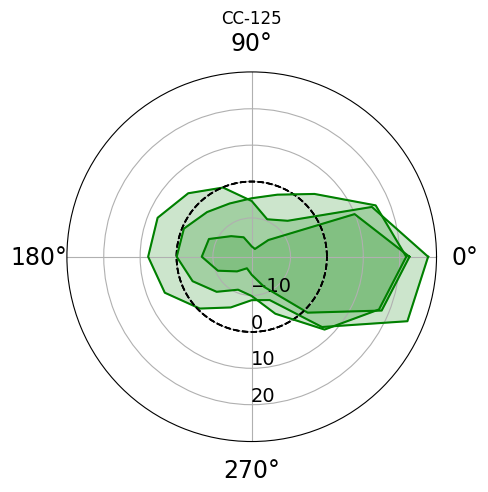

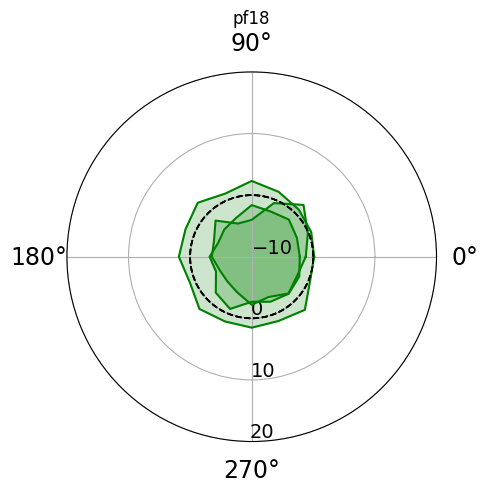

In [3]:
fileDict = {'CC-5437':'ΔCOP5.20-B2',
            'CC-5431': 'ΔCOP6-F9',
            'CC-5499':'ΔChR1 ΔChR2', 'CC-5443': 'ΔCOP5-D11',
            "CC-5448":"ΔCOP5-E6", "CC-5428": 'ΔCOP11-B9-2 (delete me)',
            'CC-3663':'shf1', "CC-2288": 'lf2-4', 
           'CC-2229': 'oda1', 'CC-2664': 'ida1', 'CC-2670': 'ida4',
           'CC-2228': 'oda1', 'CC-2672': 'oda11', 'CC-2377': 'mbo2'}

files, names=import_file_names()
modifiedNames=[fileDict[name] if name in fileDict else name for name in names]

#PROCESSING DATA
indices=[]
percent_moving=[]
for i, file in enumerate(files):
    data=pd.read_csv(file)
    data=data['Mean'].values
    list1=255-data[0:16]
    list2=255-data[16:32]
    percent_change=(100*(list2-list1)/list1)
    index=np.std((percent_change)) #==GOOD
    indices.append([modifiedNames[i], index, file])
    percent_moving.append([modifiedNames[i], percent_change, file])

#PLOTTING INDIVIDUAL REPLICATES
percent_df=pd.DataFrame(percent_moving, columns=['strain', 'phototaxis index', 'file'])
strains=np.unique(percent_df['strain'])
angles=np.linspace(0, 2*np.pi, 16, endpoint=False).tolist()
angles += angles[:1]
color=['red', 'green', 'cyan']
for i, strain in enumerate(strains):
    sub_df=percent_df.loc[percent_df['strain']== strain]
    fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
    count=0
    for index, row in sub_df.iterrows():
        count=+1
        #fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}) #uncoment for 1 Replicate/axis
        values = list(row[1])
        values += values[:1] #going back to start
        # ax.set_ylim([-10,40])
        ax.set_title(strain)
        rads = np.arange(0, (2 * np.pi), 0.01) 
        # plotting the circle 
        ax.plot(rads, ([0] * len(rads)), 'k--', linewidth=1.2) 

        ax.plot(angles, values, color=color[count])
        ax.fill(angles, values, alpha=0.2, color=color[count])
        lines, labels = plt.thetagrids(range(0, 360, 90))
        ax.tick_params(pad=10)
        ax.set_yticks(np.arange(-10, 25, 10))
        ax.xaxis.set_tick_params(labelsize=17)
        ax.yaxis.set_tick_params(labelsize=14)
        ax.set_rlabel_position(-90.5) 
    plt.show()
    
  



#saving output
df=(pd.DataFrame(indices, columns=['strain', 'phototaxis index', 'file']))
#df.to_csv('phototaxis index.csv')


### Bar Graph

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
C:\Users\lexis\AppData\Local\Temp\ipykernel_21036\3681998428.py:280: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  meanVal = sub_df.groupby([groupBy]).mean()
C:\Users\lexis\AppData\Local\Temp\ipykernel_21036\3681998428.py:281: FutureWarning: The default value of numeric_only in DataFrameGroupBy.std is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  stdVal = sub_df.groupby([groupBy]).std()


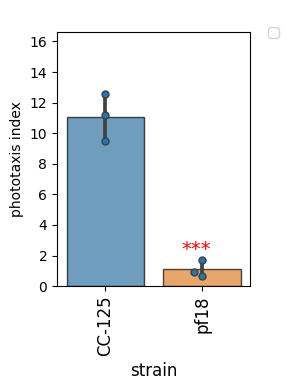

In [6]:
fig, axes = plt.subplots(1, 1, figsize=(3,4))
formatted_sns_with_stats(df, plotting='phototaxis index', groupBy='strain', plot_type=['barplot', 'swarmplot'], 
                             split_plot_by=None, split_axis_by=None,
                             hatching=None,  hatch_legend=None, color_dict=None,
                             stat_test='ttest_ind', control='CC-125', order=None, ax=axes)
plt.savefig('PHOTOTAXIS.jpg')
